# Security Investments (ROSI)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data preparation

In [2]:
# data source: https://surfdrive.surf.nl/files/index.php/s/CZWfWQp3VKGKa8m
df = pd.read_csv('../SecurityMetrics/data_with_ports.csv.gz', sep='|', compression='gzip')

C:\Users\newbi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (15,17,19,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# parse string to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['start_time'] = pd.to_datetime(df['start_time'], format='%Y-%m-%dT%H:%M:%S+09:00')
df['stop_time'] = pd.to_datetime(df['stop_time'], format='%Y-%m-%dT%H:%M:%S+09:00')

In [4]:
# subset hosting providers only
dfASesHosting = df.loc[df["as_type"] == "hosting"]
#dfASesHosting.info() # premilary inspection

# drop columns with all null values
dfASesHosting.drop(columns=["tg_op", "subs"], inplace=True)

# fix null values in `region`
dfASesHosting[dfASesHosting.region.isna()][["cc", "region"]].drop_duplicates() # found US and CA have region = NaN
dfASesHosting.region.fillna("NA", inplace=True) # NA = North America

C:\Users\newbi\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\newbi\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [5]:
dfASesHosting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 473792 entries, 2948 to 5697809
Data columns (total 33 columns):
target_ip                 473792 non-null object
date                      473792 non-null datetime64[ns]
sensor_id                 473792 non-null object
service                   473792 non-null object
start_time                473792 non-null datetime64[ns]
stop_time                 473792 non-null datetime64[ns]
duration                  473792 non-null float64
packets                   473792 non-null int64
raw_country               473792 non-null object
raw_as                    473792 non-null object
raw_hostname              473792 non-null object
udp_port_list             473792 non-null object
pyasn_as                  473792 non-null float64
pyasn_as_bgp_size         472991 non-null float64
cc                        473792 non-null object
region                    473792 non-null object
is_oecd                   473792 non-null float64
as_type                  

In [6]:
from random import randint

dfASesHosting.iloc[randint(0, len(dfASesHosting))]

target_ip                                                     178.63.68.198
date                                                    2015-12-16 00:00:00
sensor_id                                                         sensor002
service                                                                 dns
start_time                                              2015-12-16 07:15:54
stop_time                                               2015-12-16 07:17:44
duration                                                                110
packets                                                                 842
raw_country                                                         Germany
raw_as                                          AS24940 Hetzner Online GmbH
raw_hostname                                                s8.tecspace.net
udp_port_list                                                      [155227]
pyasn_as                                                              24940
pyasn_as_bgp

## Metadata

Decsriptions of the metadata (Cheung, 2017):

| Column | Description |
| ------ | ----------- |
| `target_ip` | The IP address that has been targeted by a DDoS attackc |
| `date` | The date of attack |
| `sensor_id` | The name of the honeypot that monitored the attack traffic |
| `service` | The protocol that was used to execute the attack |
| `start_time` | The start time of the attack |
| `stop_time` | The stop time of the attack |
| `duration` | Attack duration |
| `pyasn_as` | The autonomous system number identifying which AS is routing traffic for the attacked IP |
| `pyasn_as_bpg_size` | The total number of IP addresses that the AS routes |
| `cc` | Short form of the country where the IP address seems to reside |
| `as_type` | The type of the Autonomous system (could be ISP, Hosting, EDU, etc.) |
| `tg_op` | A string identifier to ASes that are known to be Broadband ISPs |
| `caida_type` | A type identifier for ASes based on different source (CAIDA) |
| `dc` | The number of second level domains that have been observed to map to the attacked IP addresses in DNS traffic |
| `subs` | The number of subscribers for those ASes that are known to be Broadband ISPs |
| `as_ipsize_seen` | The total number of IP addresses of the AS that have been observed to be routed to IPs of the AS in DNS traffic |
| `as_domainsize_seen` | The total number of second level domains that have been observed to be routed to IPs of the AS in DNS traffic |
| `year` | The year of the attack |
| `udp_port_list` | The ports that attack packets have been sent to |


# ROSI

In [7]:
from datetime import datetime

In [8]:
dfASesHosting["attack_duration"] = dfASesHosting["stop_time"] - dfASesHosting["start_time"]
dfASesHosting["attack_duration"] = dfASesHosting["attack_duration"].dt.total_seconds()

C:\Users\newbi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\newbi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
dfASesHosting["costs_org_domain_per_second"] = dfASesHosting["as_domainsize_seen"] * 29.15

C:\Users\newbi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
dfASesHosting["total_costs_attack"] = dfASesHosting["attack_duration"] * dfASesHosting["costs_org_domain_per_second"]

C:\Users\newbi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [68]:
dfASesHosting["risk_height"] = 0.17 * dfASesHosting["total_costs_attack"]

C:\Users\newbi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [69]:
dfASesHosting["maximum_investment"] = 0.01 * dfASesHosting["total_costs_attack"]

C:\Users\newbi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [73]:
df_mean_attacks = dfASesHosting.groupby("org").mean()

In [75]:
df_mean_attacks[df_mean_attacks.index.isin(["AMAZON"])]

,duration,packets,pyasn_as,pyasn_as_bgp_size,is_oecd,as_type_confidence,org_rangesize,org_ipsize_seen,org_domainsize_seen,org_ipsize_seen_shared,...,dc,as_ipsize_seen,as_domainsize_seen,pps,year,attack_duration,costs_org_domain_per_second,total_costs_attack,maximum_investment,risk_height
org,,,,,,,,,,,,,,,,,,,,,
AMAZON,1173.511503,7995.733012,15036.873194,4.683955e+06,1.0,2.947566,2294716.0,158265.0,334952.0,2991.0,...,107.777956,783851.975923,4.072161e+06,inf,2015.0,1173.511503,1.187035e+08,1.403230e+11,1.403230e+09,2.385491e+10


Text(0,0.5,'ALE unsecured situation (euro)')

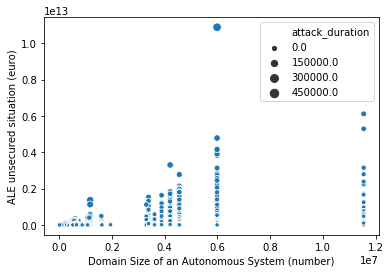

In [79]:
ax = sns.scatterplot(x="as_domainsize_seen", y="risk_height", size = "attack_duration", data=dfASesHosting)
ax.set_xlabel("Domain Size of an Autonomous System (number)")
ax.set_ylabel("ALE unsecured situation (euro)")
plt.show()

In [15]:
def secondLevelDomainName(raw_hostname):
    '''get second-level domain name'''
    if raw_hostname.count(".") >= 2:
        d3, d2, d1 = raw_hostname.rsplit(".", 2)
        if (d2 == "com") | (d2 == "co"): # e.g. "co.uk" or "com.br" 
            return raw_hostname
        else:
            return d2 + "." + d1
    else:
        return raw_hostname

In [16]:
hostingDomains = dfASesHosting[~dfASesHosting.raw_hostname.isna()]
hostingDomains = hostingDomains[hostingDomains.raw_hostname != "None"]
hostingDomains['hostname'] = hostingDomains.raw_hostname.apply(secondLevelDomainName)
hostingDomains.head()

,target_ip,date,sensor_id,service,start_time,stop_time,duration,packets,raw_country,raw_as,...,caida_type,dc,as_ipsize_seen,as_domainsize_seen,pps,year,attack_duration,costs_org_domain_per_second,total_costs_attack,hostname
2948,100.42.49.140,2014-12-25,sensor003,ssdp,2014-12-25 13:47:59,2014-12-25 14:07:44,1185.0,441,United States,AS36351 SoftLayer Technologies Inc.,...,Content,1982,542087.0,3384037.0,0.372152,2014,1185.0,98644678.55,1.168939e+11,arvixe.com
2949,100.42.49.140,2014-12-25,sensor005,ssdp,2014-12-25 13:47:51,2014-12-25 14:07:49,1198.0,433,United States,AS36351 SoftLayer Technologies Inc.,...,Content,1982,542087.0,3384037.0,0.361436,2014,1198.0,98644678.55,1.181763e+11,arvixe.com
2950,100.42.49.140,2014-12-25,sensor007,ssdp,2014-12-25 13:47:50,2014-12-25 14:07:46,1196.0,440,United States,AS36351 SoftLayer Technologies Inc.,...,Content,1982,542087.0,3384037.0,0.367893,2014,1196.0,98644678.55,1.179790e+11,arvixe.com
2951,100.42.52.96,2014-12-23,sensor001,dns,2014-12-23 17:33:13,2014-12-23 17:48:00,887.0,491,United States,AS36351 SoftLayer Technologies Inc.,...,Content,628,542087.0,3384037.0,0.553551,2014,887.0,98644678.55,8.749783e+10,mysitehosted.com
2952,100.42.57.238,2014-12-20,sensor001,ntp,2014-12-20 13:48:46,2014-12-20 13:50:47,121.0,2927,United States,AS21788 Network Operations Center Inc.,...,Content,2,542087.0,3384037.0,24.190083,2014,121.0,98644678.55,1.193601e+10,mysitehosted.com


In [17]:
# top ten hosting providers under most attacks
mostAttackedHostingProviders = hostingDomains.hostname.value_counts()[:10]
mostAttackedHostingProviders

amazonaws.com            16469
your-server.de           15856
poneytelecom.eu          13582
lstn.net                  7391
softlayer.com             6454
alojandoargentina.net     5366
ovh.net                   4535
kimsufi.com               3416
as15003.net               2070
beastnode.com             2016
Name: hostname, dtype: int64

In [45]:
hostingDomainsMostAttacked = hostingDomains[hostingDomains.hostname.isin(mostAttackedHostingProviders.index.tolist())]
hostingDomainsMostAttacked.sort_values(by="hostname")

,target_ip,date,sensor_id,service,start_time,stop_time,duration,packets,raw_country,raw_as,...,caida_type,dc,as_ipsize_seen,as_domainsize_seen,pps,year,attack_duration,costs_org_domain_per_second,total_costs_attack,hostname
297138,190.210.176.248,2014-12-16,sensor005,ntp,2014-12-16 07:40:12,2014-12-16 07:44:57,285.0,1921,Argentina,AS16814 S.A.,...,Transit/Access,0,7637.0,56244.0,6.740351,2014,285.0,1.639513e+06,4.672611e+08,alojandoargentina.net
295606,190.210.176.20,2014-10-28,sensor003,snmp,2014-10-28 16:27:20,2014-10-28 16:32:17,297.0,2337,Argentina,AS16814 S.A.,...,Transit/Access,0,7637.0,56244.0,7.868687,2014,297.0,1.639513e+06,4.869352e+08,alojandoargentina.net
295607,190.210.176.20,2014-10-28,sensor003,snmp,2014-10-28 20:00:40,2014-10-28 20:05:37,297.0,2295,Argentina,AS16814 S.A.,...,Transit/Access,0,7637.0,56244.0,7.727273,2014,297.0,1.639513e+06,4.869352e+08,alojandoargentina.net
295608,190.210.176.20,2014-10-28,sensor003,snmp,2014-10-28 23:33:32,2014-10-28 23:38:32,300.0,1191,Argentina,AS16814 S.A.,...,Transit/Access,0,7637.0,56244.0,3.970000,2014,300.0,1.639513e+06,4.918538e+08,alojandoargentina.net
295609,190.210.176.20,2014-10-28,sensor004,snmp,2014-10-28 02:10:12,2014-10-28 02:15:13,301.0,1828,Argentina,AS16814 S.A.,...,Transit/Access,0,7637.0,56244.0,6.073090,2014,301.0,1.639513e+06,4.934933e+08,alojandoargentina.net
295610,190.210.176.20,2014-10-28,sensor004,snmp,2014-10-28 05:46:26,2014-10-28 05:51:27,301.0,1938,Argentina,AS16814 S.A.,...,Transit/Access,0,7637.0,56244.0,6.438538,2014,301.0,1.639513e+06,4.934933e+08,alojandoargentina.net
295611,190.210.176.20,2014-10-28,sensor004,snmp,2014-10-28 09:20:33,2014-10-28 09:25:33,300.0,1276,Argentina,AS16814 S.A.,...,Transit/Access,0,7637.0,56244.0,4.253333,2014,300.0,1.639513e+06,4.918538e+08,alojandoargentina.net
295605,190.210.176.20,2014-10-28,sensor003,snmp,2014-10-28 12:54:45,2014-10-28 12:59:42,297.0,2225,Argentina,AS16814 S.A.,...,Transit/Access,0,7637.0,56244.0,7.491582,2014,297.0,1.639513e+06,4.869352e+08,alojandoargentina.net
295612,190.210.176.20,2014-10-28,sensor004,snmp,2014-10-28 12:54:44,2014-10-28 12:59:42,298.0,2230,Argentina,AS16814 S.A.,...,Transit/Access,0,7637.0,56244.0,7.483221,2014,298.0,1.639513e+06,4.885748e+08,alojandoargentina.net
295614,190.210.176.20,2014-10-28,sensor004,snmp,2014-10-28 20:00:39,2014-10-28 20:05:38,299.0,2305,Argentina,AS16814 S.A.,...,Transit/Access,0,7637.0,56244.0,7.709030,2014,299.0,1.639513e+06,4.902143e+08,alojandoargentina.net


In [47]:
hostingDomainsMostAttacked_mean = hostingDomainsMostAttacked.groupby("org").mean()

In [66]:
hostingDomainsMostAttacked_mean.index.unique()

Index(['278431 Sub Account', '3dCart Shopping Cart Software', '8TASP',
       'A 001Hosting Hospedagem de Sites Ltda', 'A Small Orange LLC', 'AMAZON',
       'Addmired Inc', 'Agensite', 'Aliexpress.com', 'AllisonHouse LLC',
       ...
       'softlayer.com', 'uniaohost', 'useCryptos', 'vLew Internet',
       'vansky.com', 'webRulon, LLC', 'webcode ltd',
       'webserver-a-rackshack.directi.com', 'xfreesoft', 'xu zhang wei'],
      dtype='object', name='org', length=346)

In [63]:
file2write=open("all_orgs",'w')
file2write.write(str(hostingDomainsMostAttacked_mean.index.unique()))
file2write.close()

In [61]:
hostingDomainsMostAttacked_mean[hostingDomainsMostAttacked_mean.index.isin(["AMAZON", "softlayer.com", ])]

,duration,packets,pyasn_as,pyasn_as_bgp_size,is_oecd,as_type_confidence,org_rangesize,org_ipsize_seen,org_domainsize_seen,org_ipsize_seen_shared,org_is_hosting,dc,as_ipsize_seen,as_domainsize_seen,pps,year,attack_duration,costs_org_domain_per_second,total_costs_attack
org,,,,,,,,,,,,,,,,,,,
AMAZON,1171.031402,8005.480238,15027.528966,4.678103e+06,1.0,2.953438,2.294716e+06,158265.0,334952.0,2991.0,1.0,108.682729,783061.402815,4.075090e+06,inf,2015.000000,1171.031402,1.187889e+08,1.402195e+11
softlayer.com,1059.037736,9863.226415,36351.000000,1.669632e+06,1.0,2.000000,8.986698e+02,570.0,1359.0,37.0,1.0,2.452830,542087.000000,3.384037e+06,14.256196,2014.367925,1059.037736,9.864468e+07,1.044684e+11


## Hosting providers

In [ ]:
def secondLevelDomainName(raw_hostname):
    '''get second-level domain name'''
    if raw_hostname.count(".") >= 2:
        d3, d2, d1 = raw_hostname.rsplit(".", 2)
        if (d2 == "com") | (d2 == "co"): # e.g. "co.uk" or "com.br" 
            return raw_hostname
        else:
            return d2 + "." + d1
    else:
        return raw_hostname

In [ ]:
hostingDomains = dfASesHosting[~dfASesHosting.raw_hostname.isna()]
hostingDomains = hostingDomains[hostingDomains.raw_hostname != "None"]
hostingDomains['hostname'] = hostingDomains.raw_hostname.apply(secondLevelDomainName)
hostingDomains.head()

In [14]:
# top ten hosting providers under most attacks
mostAttackedHostingProviders = hostingDomains.hostname.value_counts()[:10]
mostAttackedHostingProviders

NameError: name 'hostingDomains' is not defined

In [ ]:
# as_ipsize_seen

hostingDomains_IpSizeSeen = {
    host : hostingDomains.loc[hostingDomains.hostname == host]
                         .as_ipsize_seen
                         .value_counts()
                         .reset_index()
    for host in mostAttackedHostingProviders.index
}

# weighted domain size

hostingDomains_IpSizeSeenWeighted = {
    host: (d["index"] * d["as_ipsize_seen"]).sum() / d["as_ipsize_seen"].sum()
    for (host, d) in hostingDomains_IpSizeSeen.items()
}

hostingDomains_IpSizeSeenWeighted = pd.DataFrame.from_dict(hostingDomains_IpSizeSeenWeighted, 
                                                           orient="index", columns=["ipsize_seen_weighted"])
hostingDomains_IpSizeSeenWeighted

In [ ]:
# as_domainsize_seen

hostingDomains_DomainSizeSeen = {
    host : hostingDomains.loc[hostingDomains.hostname == host]
                         .as_domainsize_seen
                         .value_counts()
                         .reset_index()
    for host in mostAttackedHostingProviders.index
}

# weighted domain size

hostingDomains_DomainSizeSeenWeighted = {
    host: (d["index"] * d["as_domainsize_seen"]).sum() / d["as_domainsize_seen"].sum()
    for (host, d) in hostingDomains_DomainSizeSeen.items()
}

hostingDomains_DomainSizeSeenWeighted = pd.DataFrame.from_dict(hostingDomains_DomainSizeSeenWeighted, 
                                                               orient="index", columns=["domainsize_seen_weighted"])
hostingDomains_DomainSizeSeenWeighted

In [ ]:
hostingDomainsMostAttacked = hostingDomains[hostingDomains.hostname.isin(mostAttackedHostingProviders.index.tolist())]
hostingDomainsMostAttacked.sort_values(by="hostname")
hostingDomainsMostAttacked[["hostname", "pps"]].sample(5)

In [ ]:
idSortByMostAttacks = pd.DataFrame(mostAttackedHostingProviders.index, 
                                   columns=["hostname"]).reset_index()
hostingDomainsMostAttacked = (hostingDomainsMostAttacked.merge(idSortByMostAttacks, how="left", 
                                                               left_on="hostname", right_on="hostname")
                                                        .sort_values(by="index", ascending=False))
hostingDomainsMostAttacked[["hostname", "pps"]].head()

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(9, 7), sharey=True)

sns.boxplot(data=hostingDomainsMostAttacked, x="pps", y="hostname", orient="h", 
            fliersize=2.5, ax=ax[1])
ax[1].set_ylabel("")
ax[1].set_xlabel("(b)")
ax[1].set_title("Attack strength\n[pps]")

sns.boxplot(data=hostingDomainsMostAttacked, x="duration", y="hostname", orient="h", 
            fliersize=2.5, ax=ax[2])
ax[2].set_ylabel("")
ax[2].set_xlabel("(c)")
ax[2].set_title("Attack duration\n[ms]")

ax[0].barh(mostAttackedHostingProviders.index, mostAttackedHostingProviders.values, height=0.3)
ax[0].set_title("Occurrence of\nattacks")
ax[0].set_xlabel("(a)")
ax[0].set_xlim([0, 20000])
ax[0].set_xticklabels(["0", "1e4", "2e4"])

ax[3].barh(hostingDomains_IpSizeSeenWeighted.index,
           hostingDomains_IpSizeSeenWeighted.ipsize_seen_weighted, height=0.3)
ax[3].set_title("IP size\n(weighted)")
ax[3].set_xlabel("(d)")

ax[4].barh(hostingDomains_DomainSizeSeenWeighted.index,
           hostingDomains_DomainSizeSeenWeighted.domainsize_seen_weighted, height=0.3)
ax[4].set_title("Domain size\n(weighted)")
ax[4].set_xlabel("(e)")

ax[0].invert_yaxis()
ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')
ax[2].grid(linestyle='--')
ax[3].grid(linestyle='--')
ax[4].grid(linestyle='--')

plt.tight_layout()
fig.savefig("images/top-ten-host-providers.png")

## Performance among hosting providers

In [ ]:
hostingDomains.info()

In [ ]:
hosting = ["amazonaws.com", "ovh.net", "softlayer.com"]

sns.pairplot(hostingDomains[hostingDomains.hostname.isin(hosting)][["duration", "pps", "packets", "hostname"]], 
             hue="hostname", diag_kind="kde")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2.5))

ax.plot(hostingDomains[hostingDomains.hostname == "amazonaws.com"].groupby("date").hostname.value_counts().unstack())
ax.plot(hostingDomains[hostingDomains.hostname == "softlayer.com"].groupby("date").hostname.value_counts().unstack())
ax.plot(hostingDomains[hostingDomains.hostname == "ovh.net"].groupby("date").hostname.value_counts().unstack())
ax.legend(["amazonaws.com", "softlayer.com", "ovh.net"])
ax.set_ylabel("Occurrence of attacks")

fig.savefig("images/attacks-per-day-three-hosting")

In [ ]:
hostingDomains[hostingDomains.hostname == "amazonaws.com"] # "2015-08-30"

## Misc

In [ ]:
# fix null values in `org`

dfASesHosting[dfASesHosting.org.isna()][["raw_hostname", "raw_as", "org"]].drop_duplicates()

In [ ]:
dfASesHosting[dfASesHosting.raw_as.str.contains("SoftLayer")].raw_as.unique()


In [ ]:
dfASesHosting[dfASesHosting.raw_as.str.contains("Amazon")][["raw_as", "org", "caida_type"]].drop_duplicates()

In [ ]:
dfASesHosting.loc[dfASesHosting.raw_as == "AS21844 SoftLayer Technologies Inc."][["target_ip", "raw_hostname", "raw_as", "org", "caida_type"]].drop_duplicates()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.date.value_counts().sort_index())
ax.set_title("Number of observed DDoS attacks per day")

In [ ]:
# number of attacks per day, per AS type

nrAttacksPerASType = (df[["as_type", "date"]].groupby("date")
                                             .as_type.value_counts()
                                             .unstack().fillna(0))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(nrAttacksPerASType)
ax.set_title("Number of observed DDoS attacks per day, per AS type")
ax.legend(nrAttacksPerASType.columns.tolist(), title="AS type")

In [ ]:
# AS victims, ISP broadband & hosting

asesHosting = df.loc[df["as_type"] == "hosting"]
asesIspBroadband = df.loc[df["as_type"] == "isp-broadband"]

In [ ]:
asesHostingNrAttacks = asesHosting.org.value_counts()

In [ ]:
# top ten hosting providers under most attacks 
asesHostingNrAttacks[:10]

In [ ]:
(asesHosting.loc[asesHosting.org == "Amazon.com"]
            .loc[asesHosting.as_ipsize_seen == 748413.0]
            [["org", "as_ipsize_seen", "raw_as"]]
            .drop_duplicates())


In [ ]:
(asesHosting.loc[asesHosting.org.isin(asesHostingNrAttacks.index.tolist()[:10])]
                [["org", "as_ipsize_seen", "as_domainsize_seen", "org_tag"]].drop_duplicates())

In [ ]:
(asesHosting.loc[asesHosting.org == "Amazon.com"]
                [["org", "as_ipsize_seen", "as_domainsize_seen", "org_tag", "raw_as", "raw_hostname"]].drop_duplicates())

In [ ]:
# number of attacks against hosting providers per day, per org

nrAttacksHostingPerOrg = (asesHosting.loc[asesHosting.org.isin(asesHostingNrAttacks.index.tolist()[:5])]
                                         [["org", "date"]]
                                     .groupby("date")
                                     .org.value_counts()
                                     .unstack()
                                     .fillna(0))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(nrAttacksHostingPerOrg)
ax.set_title("Occurence of DDoS attacks against hosting providers per day, \ntop five companies under most attacks")
# ax.set_yscale('log')
ax.legend(nrAttacksHostingPerOrg.columns.tolist(), title="Company")
ax.figure.savefig("images/nrAttacksHostingTopFiveOrgs.png")

In [ ]:
asesRawAsAmazon = asesHosting.loc[asesHosting.raw_as.str.contains("Amazon")]

asesRawAsAmazon.loc[asesRawAsAmazon.org == "Facebook"].iloc[0]